In [58]:
#Importan las librerias necesarias
from qutip import *
import qutip as qt

import numpy as np
import matplotlib.pyplot as plt

In [59]:
from scipy.signal import find_peaks

# Hamiltoniano

In [60]:
#Parámetros del sistema

#Número de fotones es tres, pero se debe incluir la posibilidad de que no hayan fotones dentro del sistema
N=4

#Número de emisores
n=3

#Momentum angular total
j=3/2

# #Proyección de j
# m=-j

#Diferencia energética cavidad
wc=1

#Diferencia energética emisores
wa=1

#Fuerza de acoplamiento campo-materia
A=0.1

#Término que representa esa fuerza de acoplamiento en ese número de emisores
g=A/((n)**(1/2))


#Operadores del sistema


#Operadores de momentum angular para los emisores
jz=tensor(jmat(j,'z'), identity(N))

jmin=tensor(jmat(j,'-'), identity(N))

jmax=tensor(jmat(j,'+'), identity(N))



#Operador destrucción de los modos de cavidad
#La forma de la identity se hizo para que cuadrara las dimensiones con
#respecto a los operadores de materia
a =tensor(identity(jmin.dims[0][0]),destroy(N))


#Hamiltoniano de Tavis-Cummings
htc=wa*jz + wc*a.dag()*a  + g*(a.dag()*jmin + a*jmax)
htc

Quantum object: dims = [[4, 4], [4, 4]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 1.5         0.          0.          0.          0.          0.1
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          2.5         0.          0.          0.          0.
   0.14142136  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          3.5         0.          0.          0.
   0.          0.17320508  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          4.5         0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.5         0.
   0.          0.          0.          0.11547005  0.          0.
   0.          0.          0.        

# Estados

In [61]:
#Estados para la parte fotónica

#|0> Estado base fotónico
p0=qt.fock(N,0) 

#|1> Primer modo de excitación
p1=qt.fock(N,1) 

# |2> Segundo modo de excitación
p2=qt.fock(N,2) 

# |3> Tercer modo de excitación
p3=qt.fock(N,3) 

In [62]:
#Estados para la parte de materia...Aquí estoy usando un estado diferente de Dicke. Estoy usando un marco de 
#Fock para los estados de Dicke. Necesito el estado de Dicke para crear una condición inicial (estado inicial)
#para resolver el Hamiltoniano...

#|0> 'Estado base de la materia'
d0=qt.basis(int(2*j+1), 0, 0)

#|1> 'Primer estado exitado de la materia'
d1=qt.basis(int(2*j+1), 1, 0)
d2=qt.basis(int(2*j+1), 2, 0)

# |3> 'Máximo esta exitado'
d3=qt.basis(int(2*j+1), n, 0)
d3



Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]

# Base Global

In [63]:
#Aunque aquí exactamente no tengo -J. 
#¿El estado base tiene el *índice* cero. Ese índice indica, el valor -J? 

# |-J,3>
d0p3=tensor([d0,p3])
d0p3

# |-J+1,2>
d1p2=tensor([d1,p2])
d1p2
# |-J+2,1>
d2p1=tensor([d2,p1])
d2p1
# |-J+3,0>
d3p0=tensor([d3,p0])
d3p0

Quantum object: dims = [[4, 4], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

# Triple Estado Estelar como condición inicial

In [64]:
#Coeficientes de la...
n0=((2)**(1/2))/3
n3=((7)**(1/2))/3
#...condicion inicial

star=n0*p0+n3*p3
#Este es el que según yo debería sevir, ya que es el que tienen a los emisores en el estado base.
# initial=tensor(d0,star)

#Pero este tiene a los emisores en sus estados excitados, y es el que reproduce las gráficas más pare
#cidas al artículo. 
initial=tensor(d3,star)

initial.full()

array([[0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.47140452+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.8819171 +0.j]])

# Solución de la ecuación de Schrodinger

In [65]:
B=3000
#Tiempo en el que evoluciona el sistema
tlist=np.linspace(start=0,stop=B,num=B)

#Solución de la ecuación de Schrödinger
resultado=sesolve(htc, initial, tlist, e_ops=None, args=None, options=None, progress_bar=None, _safe_mode=True)

#Forma de acceder a los estados del sistema
resultado.states

#El número de estados que surgen, corresponde al numero num
#ya que son los 'puntos' que se toman del lapso. En cada punto, se conocen 
#los estados del sistema.
len(resultado.states)

3000

# Matriz de densidad 

In [66]:
def rho(x):
    "Parámetro x: x es el indice del estado correspondiente en resultado.states. La salida es la matriz n\
    de densidad a cada estado. Tiene que ser UN número menor al número de estados puestos en el linspace del sesolve"
    
    return(resultado.states[x]*resultado.states[x].dag())

#Esta sería la matriz de densidad del estado 59
rho(B-1)

Quantum object: dims = [[4, 4], [4, 4]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 6.34941636e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  6.42742473e-05-6.01375452e-02j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   2.73435176e-01+4.03731254e-04j  0.00000000e+00+0.00000000e+00j
   2.30091602e-01-2.96870180e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  6.39774432e-05-1.11055008e-01j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.000000

# Trazas Parciales

In [67]:
# ptrace(partematerial=0)
rho(0).ptrace(0)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

In [68]:
# ptrace(partefotónica=1)
rho(0).ptrace(1)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.22222222 0.         0.         0.41573971]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.41573971 0.         0.         0.77777778]]

# Entropía Lineal

In [69]:
def entropia (x):
    "Entropía lineal usando un ket"
    rho(x)
    return(entropy_linear(rho(x).ptrace(0)))


#Entropía lineal para el estado 0, es decir: t=0
entropia(0)

0.0

# Grafica de Entropía Lineal

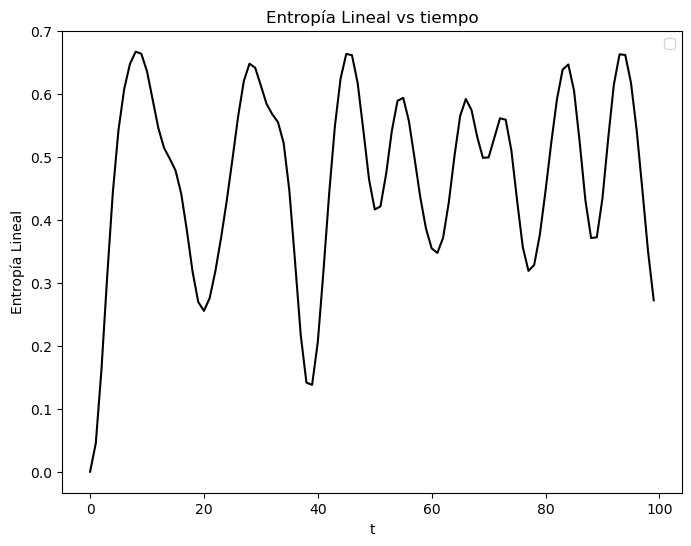

In [70]:
# Este es el  espacio donde se va a dinujar la gráfica

#El eje x va desde 0 hasta 365
x_vals=[i for i in range(100)]

#Se evalúan los valores de la entropía lineal para todos los valores de x
#valores de entropía lineal para el estado x
y1_vals=[]

for i in range(len(x_vals)):
    y1_vals.append(entropia(i))
    

plt.figure(figsize=(8, 6))
plt.plot(x_vals, y1_vals, linestyle='-', color='black')
plt.title('Entropía Lineal vs tiempo')
plt.xlabel('t')
plt.ylabel('Entropía Lineal')
plt.legend()
plt.grid(False)
plt.show()

# Función de Correlación de Segundo Orden

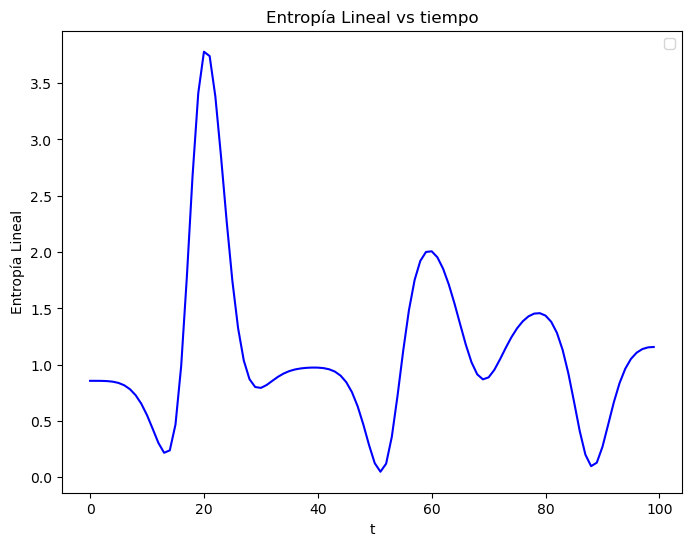

In [71]:
#operadores para crear la función de correlacion óptica de segundo orden
up=a.dag()*a.dag()*a*a
down=a.dag()*a

#Funcion de correlacion
def correlacion (x):
    "Parámetro x: x es el indice del estado correspondiente en resultado.states. La salida es la matriz n\
    de densidad a cada estado. Tiene que ser un número menor al número de estados puestos en el linspace del sesolve"
    numerador=expect(up, resultado.states[x])
    denominador=expect(down, resultado.states[x])*expect(down, resultado.states[x])
    return(numerador/denominador)

#x es un valor menor a num, que corresponde al valor del eje x de la grafica
x_vals=[i for i in range(100)]

#Valores de función de correlacion de segundo orden para el estado x
y2_vals=[]

for i in range(len(x_vals)):
    y2_vals.append(correlacion(i))
    
# Graficar los valores de x e y
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y2_vals, linestyle='-', color='b')
plt.title('Entropía Lineal vs tiempo')
plt.xlabel('t')
plt.ylabel('Entropía Lineal')
plt.legend()
plt.grid(False)
plt.show()

# Ambas Gráficas Superpuestas

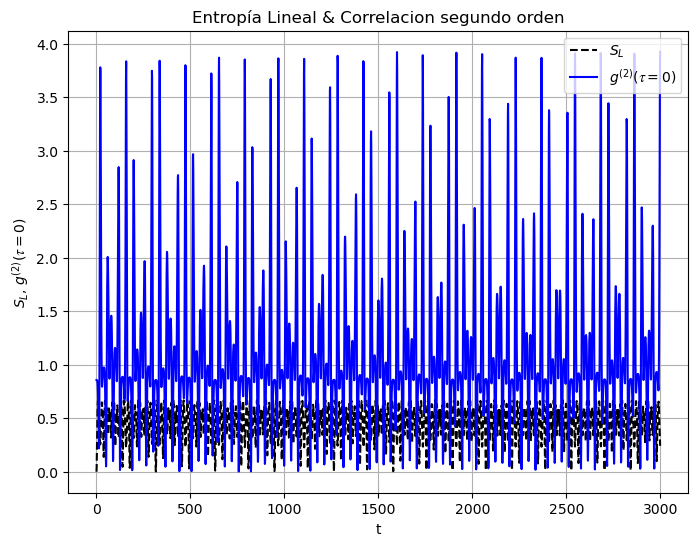

<class 'list'>


In [72]:
def entropiaycorrelacion(final):
    "Grafica entropía lineal y función de correlación óptica de segundo orden."
    "Argumento: final"
    "Corresponde al valor más grande de la absisa de la gráfica"
    
    
    x_vals=[i for i in range(final)]
    
    y2_vals=[]
    for i in range(len(x_vals)):
        y2_vals.append(correlacion(i))
    
    y1_vals=[]
    for i in range(len(x_vals)):
        y1_vals.append(entropia(i))
        

    # Graficar las dos funciones superpuestas
    plt.figure(figsize=(8, 6))

    # Graficar la primera función
    plt.plot(x_vals, y1_vals, label='$S_L$', linestyle='--',color='black')

    # Graficar la segunda función
    plt.plot(x_vals, y2_vals, label='$g^{(2)}(𝜏=0)$', linestyle='-', color='blue')



    plt.title('Entropía Lineal & Correlacion segundo orden')
    plt.xlabel('t')
    plt.ylabel('$S_L$, $g^{(2)}(𝜏=0)$')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(type(x_vals))
    
    
    
# entropiaycorrelacion(310) 310 para el caso 1.
# entropiaycorrelacion(900)
# entropiaycorrelacion(2900)
entropiaycorrelacion(B)

# Puntos Importantes

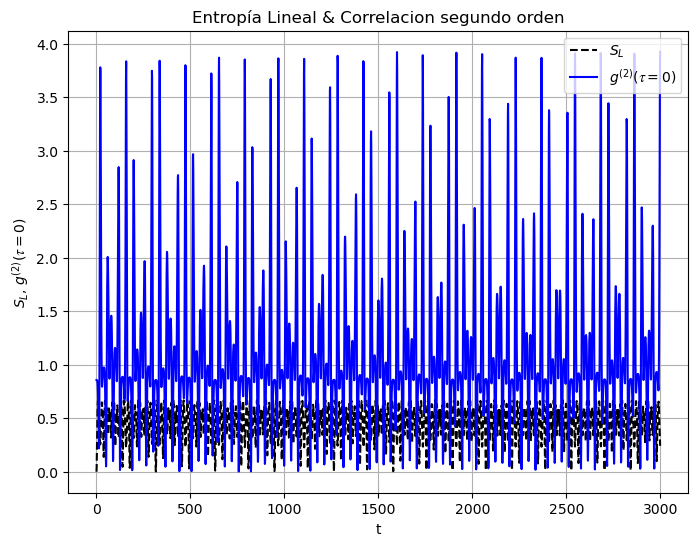

<class 'list'>


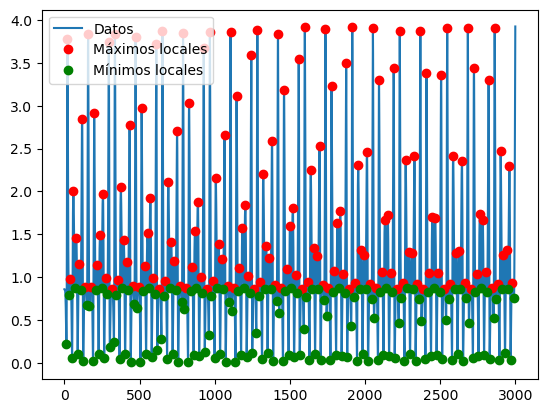

Los primeros 6 puntos críticos de la entropía lineal son:  [0, 13, 20, 30, 39, 51]


In [73]:
Puntos=[]



def entropiaycorrelacion(final):
    "Grafica entropía lineal y función de correlación óptica de segundo orden."
    "Argumento: final"
    "Corresponde al valor más grande de la absisa de la gráfica"
    
    
    x_vals=[i for i in range(final)]
    
    y2_vals=[]
    for i in range(len(x_vals)):
        y2_vals.append(correlacion(i))
    
    y1_vals=[]
    for i in range(len(x_vals)):
        y1_vals.append(entropia(i))
        

    # Graficar las dos funciones superpuestas
    plt.figure(figsize=(8, 6))

    # Graficar la primera función
    plt.plot(x_vals, y1_vals, label='$S_L$', linestyle='--',color='black')

    # Graficar la segunda función
    plt.plot(x_vals, y2_vals, label='$g^{(2)}(𝜏=0)$', linestyle='-', color='blue')



    plt.title('Entropía Lineal & Correlacion segundo orden')
    plt.xlabel('t')
    plt.ylabel('$S_L$, $g^{(2)}(𝜏=0)$')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(type(x_vals))
    
    

    #Forma de encontrar los máximos y mínimos locales de la gráfica.
    #Es indispensable que para que funcione las listas deben ser un array de numpy.
    x = np.array(x_vals)
    y = np.array(y2_vals)

    # Encuentra los máximos locales
    peaks, _ = find_peaks(y)
    # Encuentra los mínimos locales invirtiendo los datos
    min_peaks, _ = find_peaks(-y)

    # Grafica los datos
    plt.plot(x, y, label='Datos')
    # Marca los máximos locales
    plt.plot(x[peaks], y[peaks], 'ro', label='Máximos locales')
    # Marca los mínimos locales
    plt.plot(x[min_peaks], y[min_peaks], 'go', label='Mínimos locales')

    plt.legend()
    plt.show()
    
    
    # Manera de acceder a los máximos y mínimos
#     print(y[peaks],x[peaks], len(y[peaks]), len(x[peaks]))
    
    
    #Slicing de esas listas
    Wxmax=list(x[peaks][0:7])
    Wymax=list (y[peaks][0:7])
    
    Wxmin=list (x[min_peaks][0:7])
    Wymin=list (y[min_peaks][0:7])
    

  
   #Aquí lo que hago es unir los valores de x (el tiempo) para los puntos mínimos y máximos. Y con esos valores
    #específicos del tiempo puedo hacer las gráficas de Winger
    
    for i in range (len (Wxmax)):
        Wxmin.append(Wxmax[i])
    
    #Tengo que agregar el cero
    Wxmin.append(0)
    
    #Ordeno los tiempos
    Wxmin.sort()
    Puntos.append(Wxmin[0:6])
#     print('Puntos críticos: ', Wxmin[0:6])

        
    
# entropiaycorrelacion(310) 310 para el caso 1.
# entropiaycorrelacion(900)
# entropiaycorrelacion(2900)
entropiaycorrelacion(B)


#Esta es la lista de los puntos críticos (máximos y mínimos locales), en la entropía lineal.

Puntoscriticos=Puntos[0]


print('Los primeros 6 puntos críticos de la entropía lineal son: ', Puntoscriticos)

# Gráficas secundarias

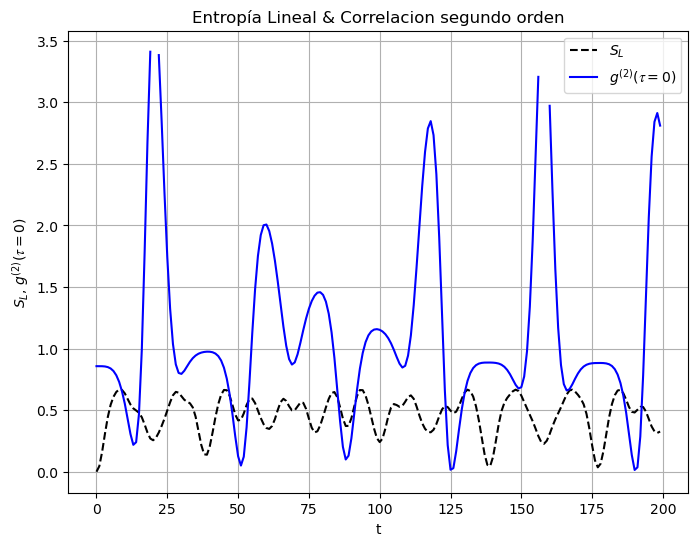

In [74]:
def secundarias (periodo, límite):
    #Gráfica para valores menores de 1
    
    x_vals=[i for i in range(periodo)]
    
    y2_vals=[]
    for i in range(len(x_vals)):
        y2_vals.append(correlacion(i))
    
    y1_vals=[]
    for i in range(len(x_vals)):
        y1_vals.append(entropia(i))
        
        
        
        
    for i in range(len(y2_vals)): 
        if y2_vals[i]>=límite:
            y2_vals[i]=np.nan
        
    
    # Graficar las dos funciones superpuestas
    plt.figure(figsize=(8, 6))

    # Graficar la primera función
    plt.plot(x_vals, y1_vals, label='$S_L$', linestyle='--',color='black')

    # Graficar la segunda función
    plt.plot(x_vals, y2_vals, label='$g^{(2)}(𝜏=0)$', linestyle='-', color='blue')



    plt.title('Entropía Lineal & Correlacion segundo orden')
    plt.xlabel('t')
    plt.ylabel('$S_L$, $g^{(2)}(𝜏=0)$')
    plt.legend()
    plt.grid(True)
    plt.show()

#Para aquirir esta gráfica muy bien, hay que jugar con el linspace que soluciona la ecuación de Schrödinger. 
secundarias(200,3.50)

# Función de Wigner

tuple

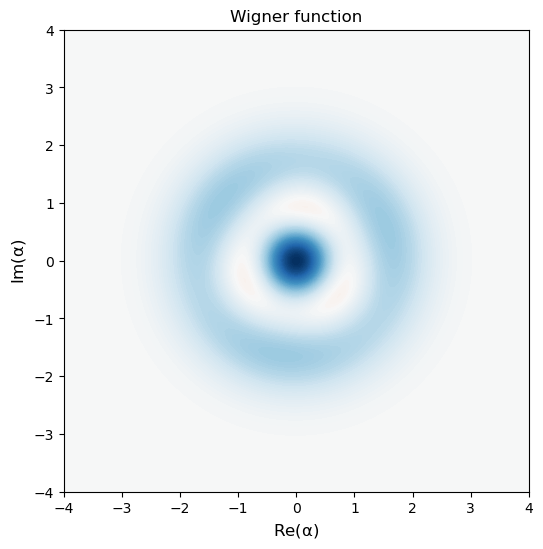

In [75]:
#Función de Wigner Fotónica
r=plot_wigner(rho(30).ptrace(1), fig=None, ax=None, figsize=(6, 6), cmap=None, alpha_max=4, colorbar=False, method='clenshaw', projection='2d')

type(r)

# Función de Wigner-Fotónica

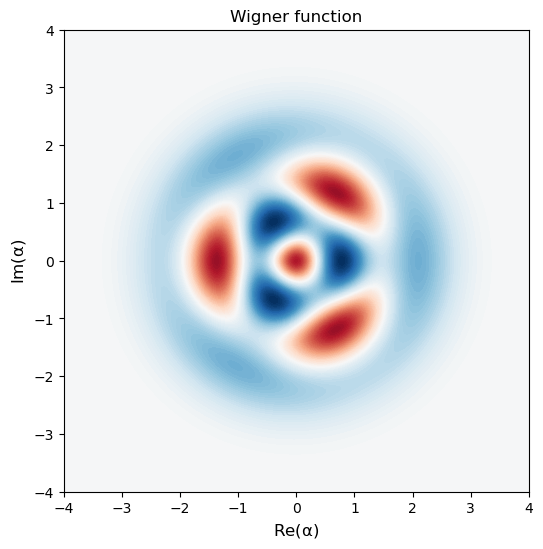

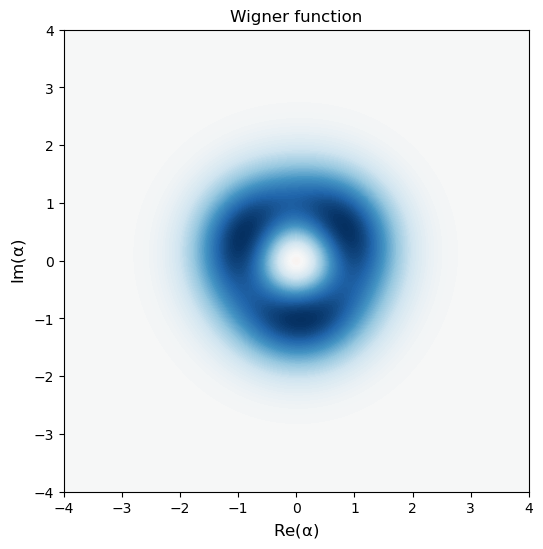

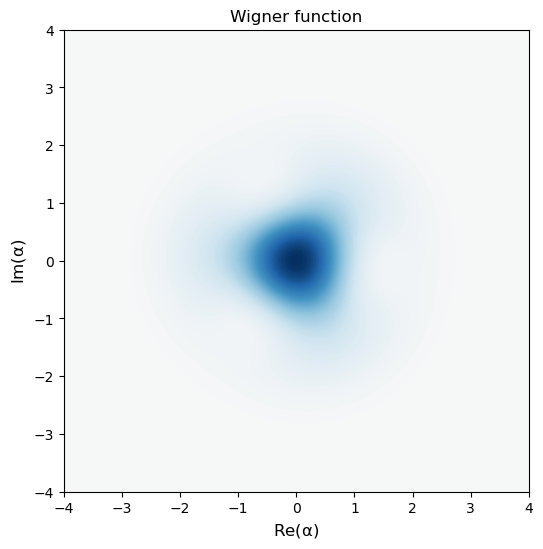

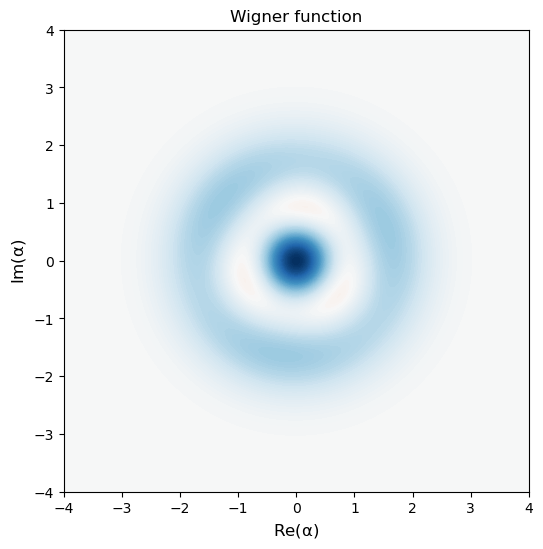

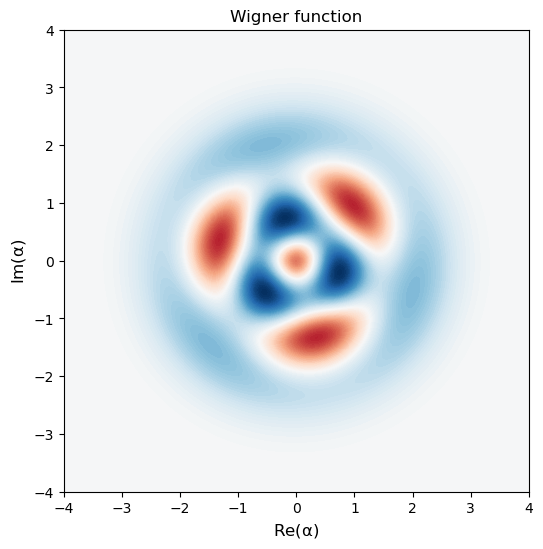

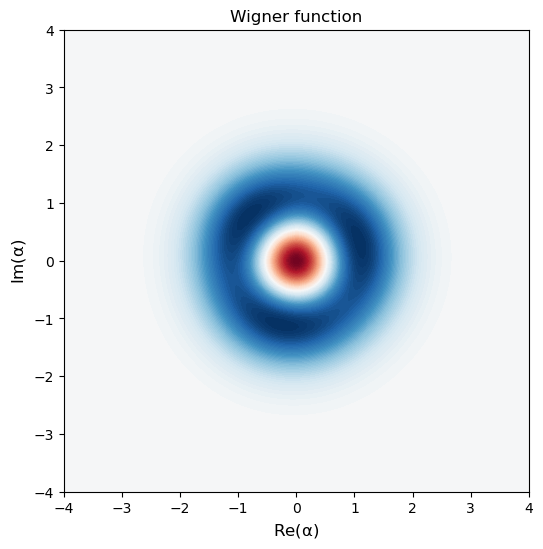

In [76]:
for i in range(len(Puntoscriticos)):
    plot_wigner(rho(Puntoscriticos[i]).ptrace(1), fig=None, ax=None, figsize=(6, 6), cmap=None, alpha_max=4, colorbar=False, method='clenshaw', projection='2d')

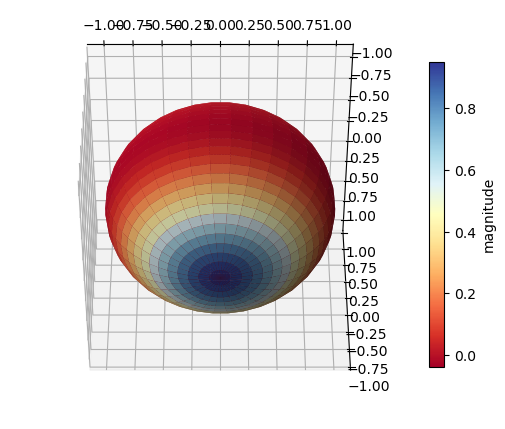

In [77]:
# Función de Wigner de Materia

psi=rho(0).ptrace(0)
theta = np.linspace(0, np.pi, 35)
phi = np.linspace(0, 2 * np.pi, 35)

W, THETA, PHI = spin_wigner(psi, theta, phi)


fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(1, 2, 2, projection='3d')
f2, a2 = plot_spin_distribution_3d(W.real, THETA, PHI, fig=fig, ax=ax)
ax.view_init(-45, -90)

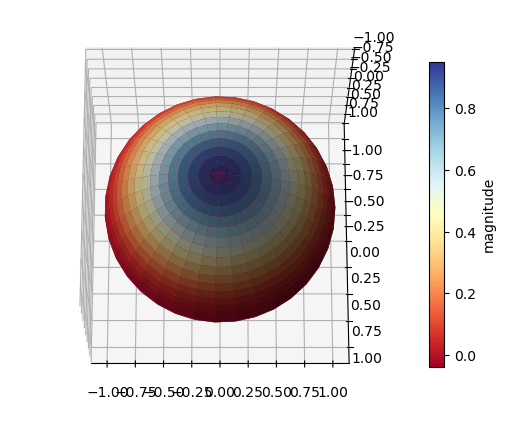

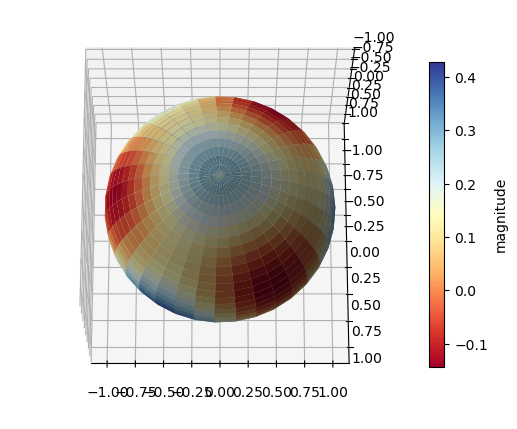

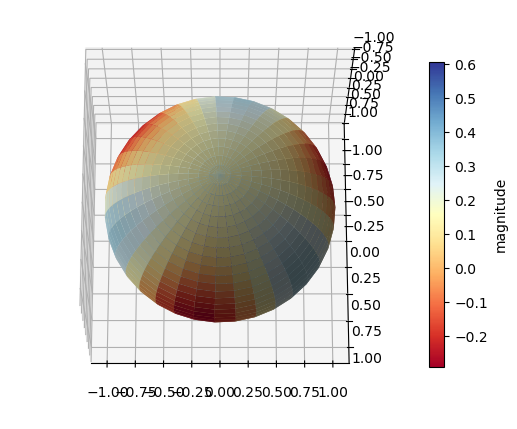

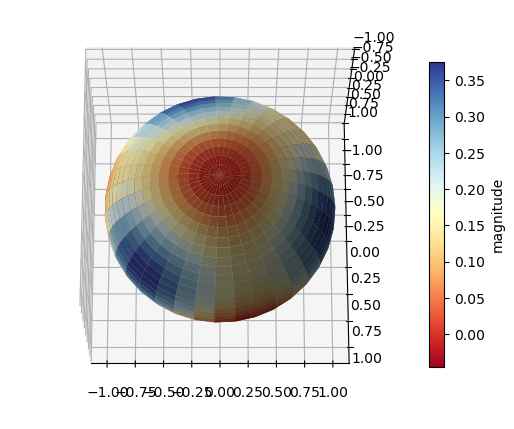

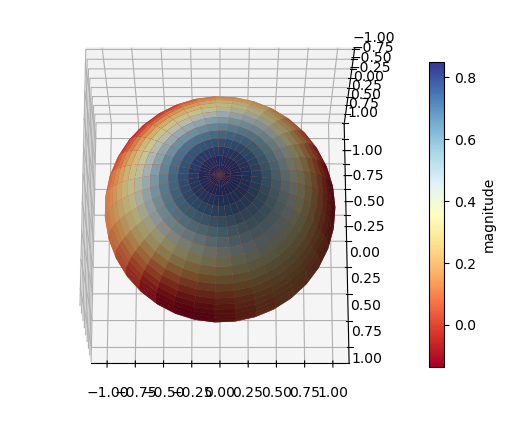

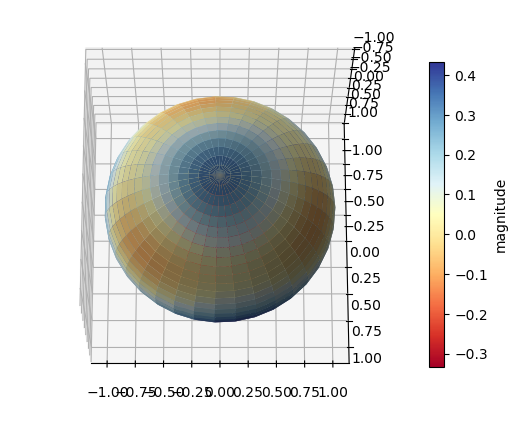

In [78]:
for i in range(len(Puntoscriticos)):
    # Función de Wigner de Materia

    psi=rho(Puntoscriticos[i]).ptrace(0)
    theta = np.linspace(0, np.pi, 36)
    phi = np.linspace(0, 2 * np.pi, 36)

    W, THETA, PHI = spin_wigner(psi, theta, phi)


    fig = plt.figure(figsize=(14,6))

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    f2, a2 = plot_spin_distribution_3d(W, THETA, PHI, fig=fig, ax=ax)
    ax.view_init(-110, -90)

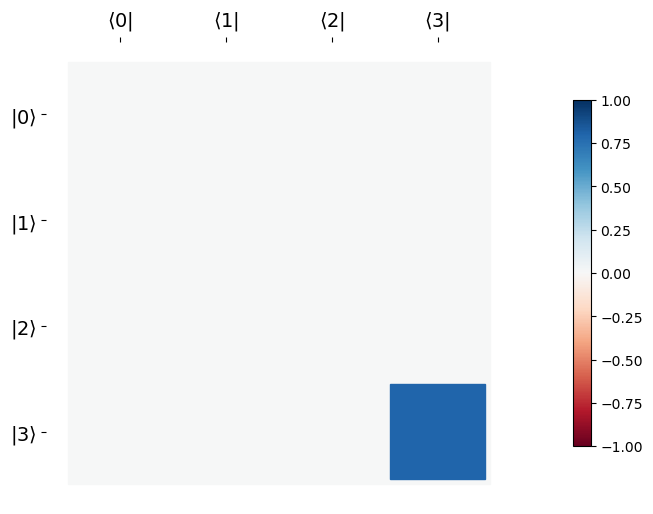

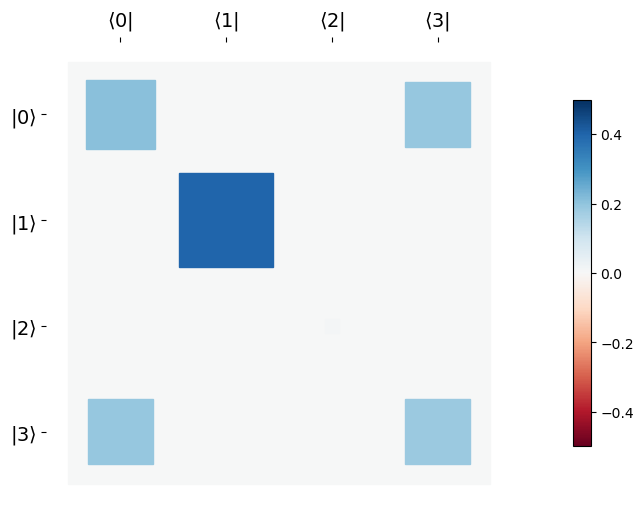

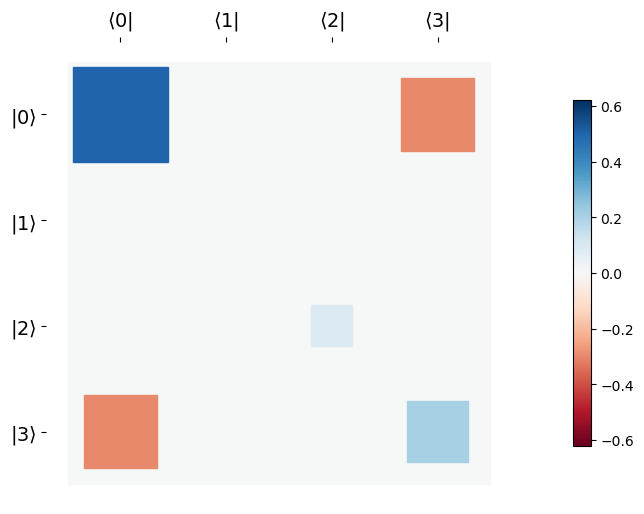

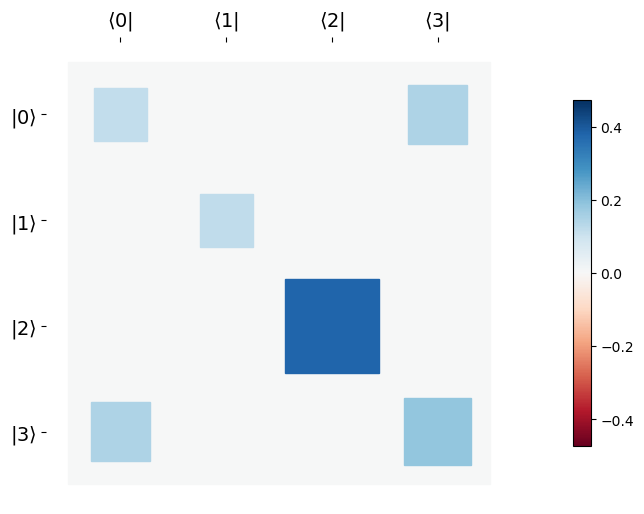

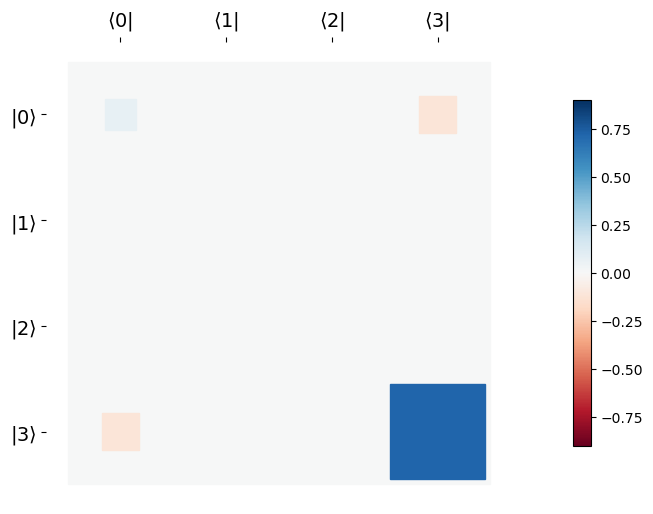

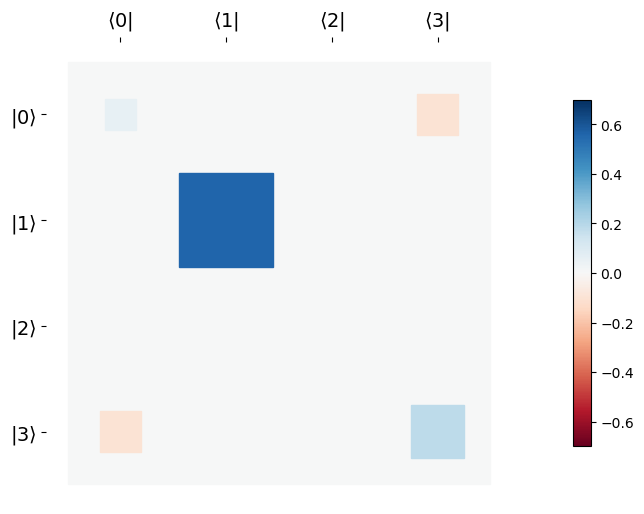

In [82]:
# Matriz de densidad para los fotones (ptrace(1))
# Matriz de densidad para la materia (ptrace(0))

for i in range(len(Puntoscriticos)):
    hinton(rho(Puntoscriticos[i]).ptrace(0))
    plt.show()

Para encontrar aquel autovector para el cual M=-J, podemos ver cuál es el autovalor que satisface esto. De esta manera podemos utilizar una condición inicial que reproduzca todas las gráficas de forma simultánea.

In [92]:
import numpy as np
from qutip import jmat, Qobj

# Define the angular momentum quantum number j (e.g., for a spin-1/2 system, j = 1/2)
j = 3/2

# Create the Jz operator
jz=tensor(jmat(j,'z'), identity(N))

# Calculate eigenstates and eigenvalues of Jz
eigenvalues, eigenstates = jz.eigenstates()

# # Print eigenvalues and corresponding eigenstates
# for i, eigenvalue in enumerate(eigenvalues):
#     print(f"Eigenvalue: {eigenvalue}")
#     print(f"Eigenstate: {eigenstates[i]}")

# # Specify the eigenvalue you are interested in (e.g., for j = 1/2, eigenvalues are -1/2 and 1/2)
# desired_eigenvalue = -3/2

# # Find and print the corresponding eigenstate
# index = np.where(np.isclose(eigenvalues, desired_eigenvalue))[0][0]
# desired_eigenstate = eigenstates[index]
# print(f"\nThe eigenstate corresponding to the eigenvalue {desired_eigenvalue} is:")
# print(desired_eigenstate)

eigenvalues, eigenstates

(array([-1.5, -1.5, -1.5, -1.5, -0.5, -0.5, -0.5, -0.5,  0.5,  0.5,  0.5,
         0.5,  1.5,  1.5,  1.5,  1.5]),
 array([Quantum object: dims = [[4, 4], [1, 1]], shape = (16, 1), type = ket
        Qobj data =
        [[0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [1.]
         [0.]
         [0.]
         [0.]]                                                              ,
        Quantum object: dims = [[4, 4], [1, 1]], shape = (16, 1), type = ket
        Qobj data =
        [[0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [1.]
         [0.]
         [0.]]                                                              ,
        Quantum object: dims = [[4, 4], [1, 1]], shape = (16, 1), type = ket
        Qobj data =
        [[0.]
     